### Udacity Self Driving Car Nanodegree - Project 4
## Advanced Lane Lines 

In [1]:
import numpy as np                 
import cv2                         
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg   
import glob                        
%matplotlib inline

In [2]:
def plotSingleImage(img1, title1, grayscale=False):
    fig, (ax1) = plt.subplots(1, figsize=(18, 6))
    fig.tight_layout()
    
    if grayscale:
        ax1.imshow(img1, cmap="gray")
    else:
        ax1.imshow(img1)
        
    ax1.set_title(title1, fontsize=18)
    
def plotImages(img1, title1, img2, title2, grayscale=False):
    """
    Plot side by side images.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig.tight_layout()
    
    if grayscale:
        ax1.imshow(img1, cmap="gray")
        ax2.imshow(img2, cmap="gray")
    else:
        ax1.imshow(img1)
        ax2.imshow(img2)
        
    ax1.set_title(title1, fontsize=18)
    ax2.set_title(title2, fontsize=18)

### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
def computeCalibrationMatrix(imgPath="./camera_cal/calibration*.jpg", displayImages=False):
    """
    Read calibration chessboard images and return computed calibration object point matrices
    """
    # Prepare object points
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    objpoints = []  # 3D points 
    imgpoints = []  # 2D points

    # Calibration images
    imageList = glob.glob(imgPath)

    for chessboard in imageList: 
        orig = cv2.imread(chessboard)
        img = cv2.imread(chessboard)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        
        # Find internal chessboard corners, returns corners array
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None) 

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)

            if displayImages:
                plt.imshow(img)
                plt.show()
                
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

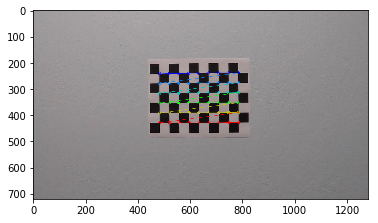

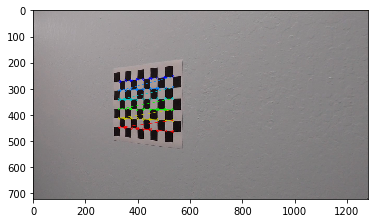

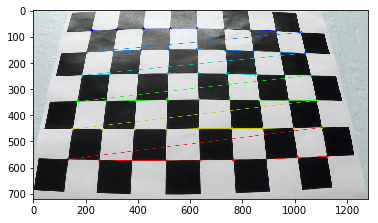

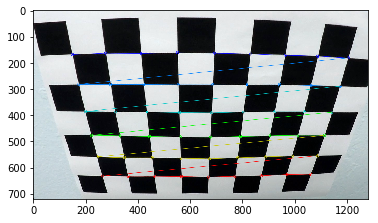

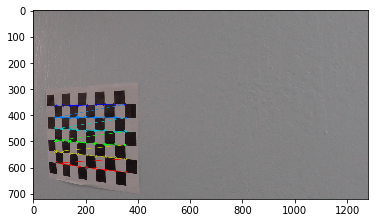

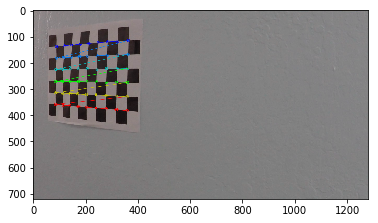

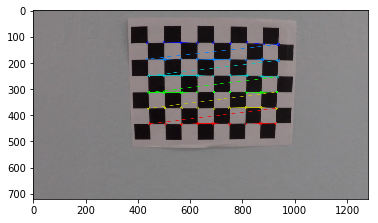

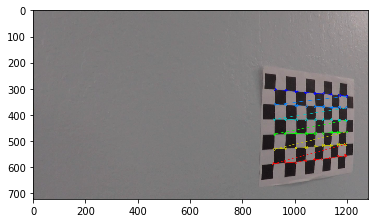

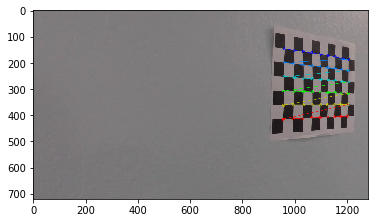

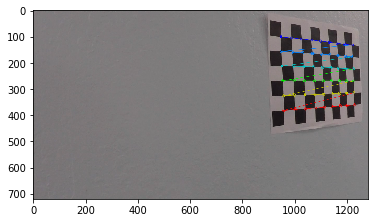

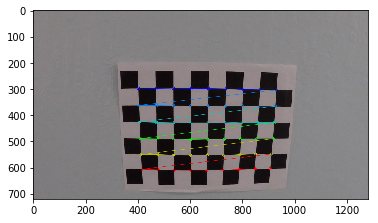

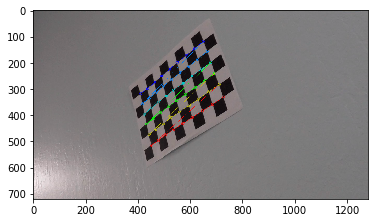

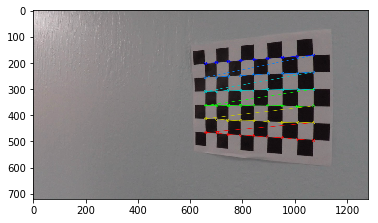

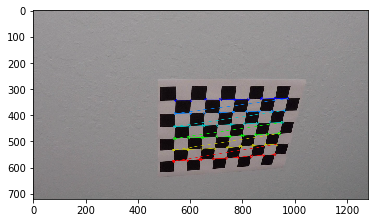

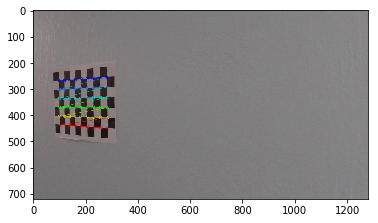

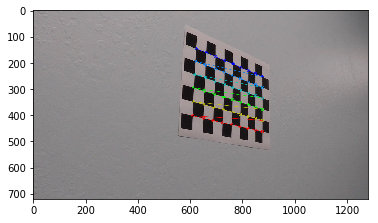

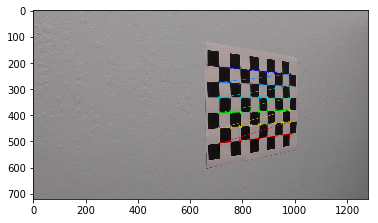

In [4]:
ret, mtx, dist, rvecs, tvecs = computeCalibrationMatrix(displayImages=True)

### 2. Apply a distortion correction to raw images.

In [5]:
def distortionCorrection(image, mtx, dist, displayImages=False):
    """
    Returns image, calibration ret, mtx, and distortion-corrected image.
    """
    
    #h, w = image.shape[:2]
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
    dst = cv2.undistort(image, mtx, dist, None, mtx)

    if displayImages:
        plotImages(image, "Original", dst, "Distortion Corrected")
        
    return dst

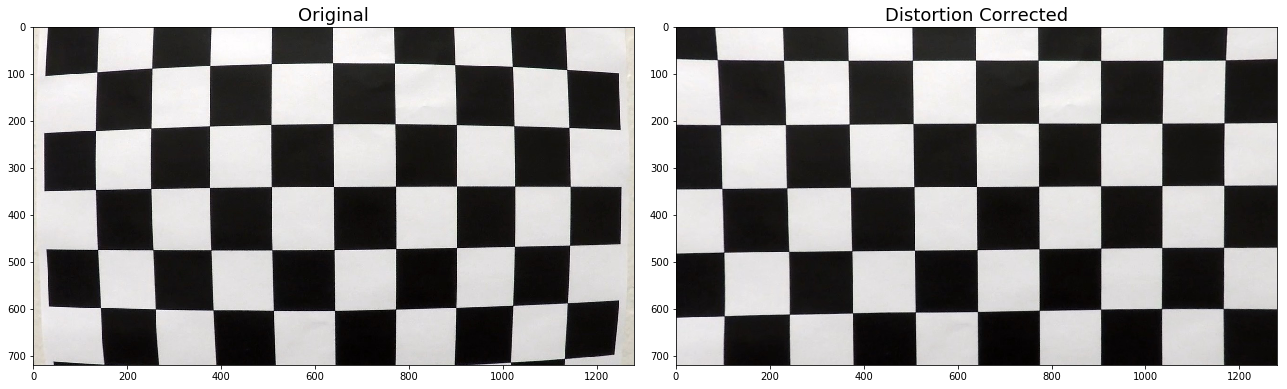

In [6]:
calibrationImage = mpimg.imread("./camera_cal/calibration1.jpg")
dst = distortionCorrection(calibrationImage, mtx, dist, displayImages=True)
mpimg.imsave("./output_images/calibration1_distortion_corrected.jpg", dst)

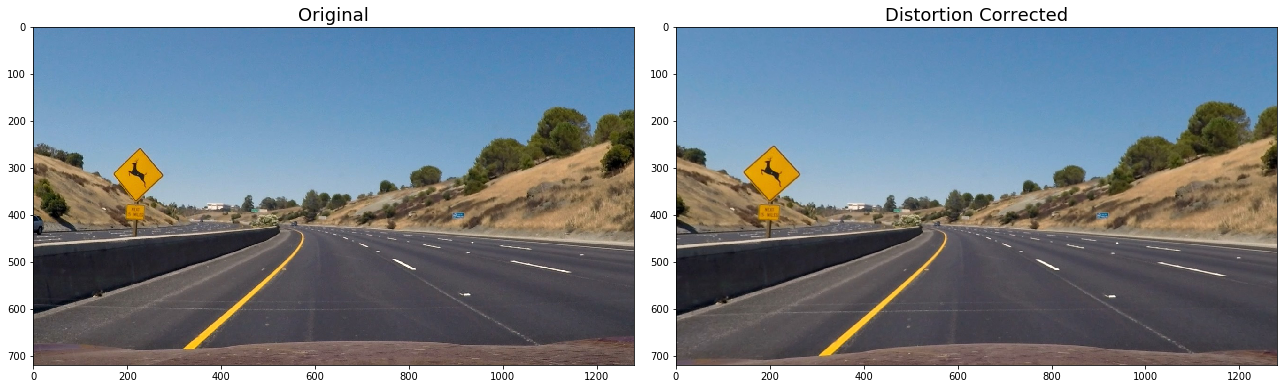

In [7]:
testImage = mpimg.imread("./test_images/test2.jpg")
dst = distortionCorrection(testImage, mtx, dist, displayImages=True)
mpimg.imsave("./output_images/test2_distortion_corrected.jpg", dst)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [8]:
def selectYellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)

    return mask

In [9]:
def selectWhite(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)

    return mask

In [10]:
def combineThreshold(image):
    yellow = selectYellow(image)
    white = selectWhite(image)

    combinedBinary = np.zeros_like(yellow)
    combinedBinary[(yellow >= 1) | (white >= 1)] = 1

    return combinedBinary

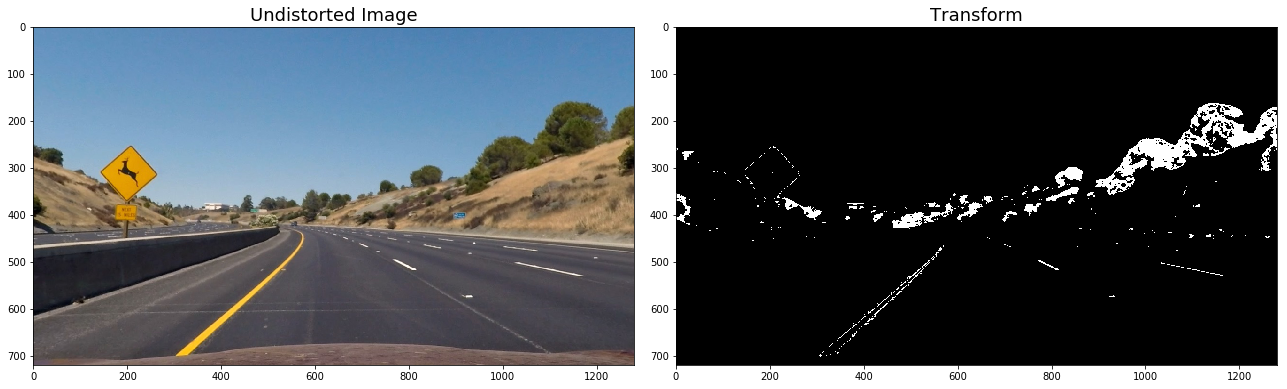

In [11]:
combinedTransform = combineThreshold(dst)

plotImages(dst, "Undistorted Image", combinedTransform, "Transform", grayscale=True)

mpimg.imsave("./output_images/test2_combined_transform.jpg", combinedTransform)

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [12]:
def perspectiveTransform(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minverse

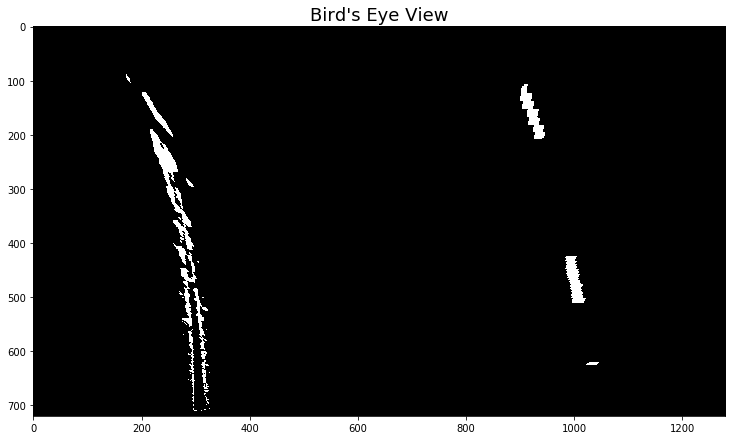

In [13]:
src = np.float32([[220, 715], [1200, 715], [750, 477], [553, 480]])    
dst = np.float32([[240, 715], [1040, 715], [1040, 300], [240, 300]])

birdsEyeView,M,Minverse = perspectiveTransform(combinedTransform, src, dst)
plotSingleImage(birdsEyeView, "Bird's Eye View", grayscale=True)
mpimg.imsave("./output_images/test2_birds_eye_view.jpg", birdsEyeView)

### 5. Detect lane pixels and fit to find the lane boundary.

In [14]:
def findLaneBoundary(img, displayImage=False):
## From Udacity Lesson 33 - Finding the Lanes

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, birdsEyeView.shape[0]-1, birdsEyeView.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if displayImage:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds,out_img

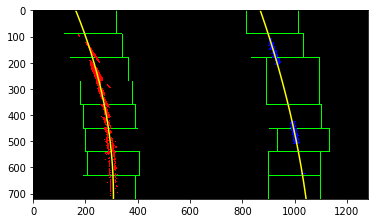

In [15]:
leftFit, rightFit, leftLaneInds, rightLaneInds, laneBoundaryImg = findLaneBoundary(birdsEyeView, displayImage=True)
mpimg.imsave("./output_images/test2_lane_boundaries.jpg", laneBoundaryImg)

### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [16]:
# Calculate radius of curvature and vehicle deviation
def calcRadiusCurvatureDeviation(img, leftFit, rightFit, leftLaneInds, rightLaneInds):
    
    lanePixelHeight = 720  
    lanePixelWidth = 700
    
    ymPerPixel = 30/lanePixelWidth 
    xmPerPixel = 3.7/lanePixelHeight 
    leftRadCurve, rightRadCurve, vehDeviation = (0, 0, 0)

    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    evaly = np.max(ploty)
    
    try:
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        leftx = nonzerox[leftLaneInds]
        lefty = nonzeroy[leftLaneInds] 
        rightx = nonzerox[rightLaneInds]
        righty = nonzeroy[rightLaneInds]

        if len(leftx) != 0 and len(rightx) != 0:
            leftFitCurve = np.polyfit(lefty*ymPerPixel, leftx*xmPerPixel, 2)
            rightFitCurve = np.polyfit(righty*ymPerPixel, rightx*xmPerPixel, 2)

            leftRadCurve = ((1 + (2*leftFitCurve[0]*evaly*ymPerPixel + leftFitCurve[1])**2)**1.5) / np.absolute(2*leftFitCurve[0])
            rightRadCurve = ((1 + (2*rightFitCurve[0]*evaly*ymPerPixel + rightFitCurve[1])**2)**1.5) / np.absolute(2*rightFitCurve[0])

        if leftFit is not None and rightFit is not None:
            carPos = img.shape[1]/2
            leftFitX = leftFit[0]*h**2 + leftFit[1]*h + leftFit[2]
            rightFitX = rightFit[0]*h**2 + rightFit[1]*h + rightFit[2]
            laneCenterPos = (rightFitX + leftFitX) / 2
            vehDeviation = (carPos - laneCenterPos) * xmPerPixel
    except:
        pass
    
    return leftRadCurve, rightRadCurve, vehDeviation

In [17]:
leftRadCurv, rightRadCurv, vehDev = calcRadiusCurvatureDeviation(combinedTransform, leftFit, rightFit, leftLaneInds, rightLaneInds)

print("Left Radius of curvature: {}m".format(leftRadCurv))
print("Right Radius of curvature: {}m".format(rightRadCurv))
print("Vehicle Deviation: {}m".format(vehDev))

Left Radius of curvature: 1575.5426179395972m
Right Radius of curvature: 423.9434038895599m
Vehicle Deviation: -0.1824501743978968m


### 7. Warp the detected lane boundaries back onto the original image.

In [18]:
def drawLane(image, overlayImage, lFit, rFit, Minverse):
    newImage = np.copy(image)
    if lFit is None or rFit is None:
        return image

    warpZero = np.zeros_like(overlayImage).astype(np.uint8)
    colorWarp = np.dstack((warpZero, warpZero, warpZero))
    
    h,w = overlayImage.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    leftFitx = lFit[0]*ploty**2 + lFit[1]*ploty + lFit[2]
    rightFitx = rFit[0]*ploty**2 + rFit[1]*ploty + rFit[2]

    leftPts = np.array([np.transpose(np.vstack([leftFitx, ploty]))])
    rightPts = np.array([np.flipud(np.transpose(np.vstack([rightFitx, ploty])))])
    pts = np.hstack((leftPts, rightPts))

    cv2.fillPoly(colorWarp, np.int_([pts]), (0,255, 0))
    cv2.polylines(colorWarp, np.int32([leftPts]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(colorWarp, np.int32([rightPts]), isClosed=False, color=(0,255,255), thickness=15)

    newWarp = cv2.warpPerspective(colorWarp, Minverse, (w, h)) 
    result = cv2.addWeighted(newImage, 1, newWarp, 0.5, 0)
    
    return result

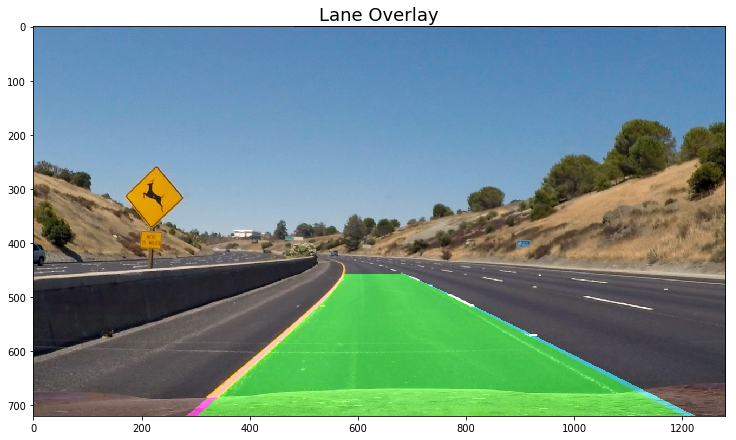

In [19]:
outputImage = drawLane(testImage, combinedTransform, leftFit, rightFit, Minverse)
plotSingleImage(outputImage, "Lane Overlay")
mpimg.imsave("./output_images/test2_lane_overlay.jpg", outputImage)

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [20]:
def overlayText(img, leftCurveRadius, rightCurveRadius, laneDeviation):
    
    font = cv2.FONT_HERSHEY_DUPLEX
    leftRCLabel = "Left Radius of Curvature: {:.1f}m".format(leftCurveRadius)
    rightRCLabel = "Right Radius of Curvature: {:.1f}m".format(rightCurveRadius)
    vehDevLabel = "Vehicle Deviation: {:.3f}m".format(laneDeviation)
    
    cv2.putText(img, leftRCLabel, (30, 80), font, 2, (255,255,255), 2)
    cv2.putText(img, rightRCLabel, (30, 140), font, 2, (255,255,255), 2)
    cv2.putText(img, vehDevLabel, (30, 200), font, 2, (255,255,255), 2)

    return img

### Pipeline

In [21]:
def pipeline(img):

    global mtx
    global dist

    # Undistort
    dst = distortionCorrection(img, mtx, dist, displayImages=False)
    
    # Threshold
    combined = combineThreshold(dst)
    
    # Perspective Transform
    srcPT = np.float32([[220, 715], [1220, 715], [750, 477], [553, 480]])    
    dstPT = np.float32([[240, 715], [1040, 715], [1040, 300], [240, 300]])
    
    pTransform, M, Minverse = perspectiveTransform(combined, srcPT, dstPT)

    # Find Lane
    leftFit, rightFit, leftLaneInds, rightLaneInds, _ = findLaneBoundary(pTransform)
    
    # Calculate Radius of Curvature
    leftCurveRadius, rightCurveRadius, laneDeviation = calcRadiusCurvatureDeviation(pTransform, leftFit, rightFit, leftLaneInds, rightLaneInds)
        
    # Overlay Lane and Text
    laneImage = drawLane(dst, pTransform, leftFit, rightFit, Minverse)
    overlayImage = overlayText(laneImage, leftCurveRadius, rightCurveRadius, laneDeviation)
    
    return overlayImage

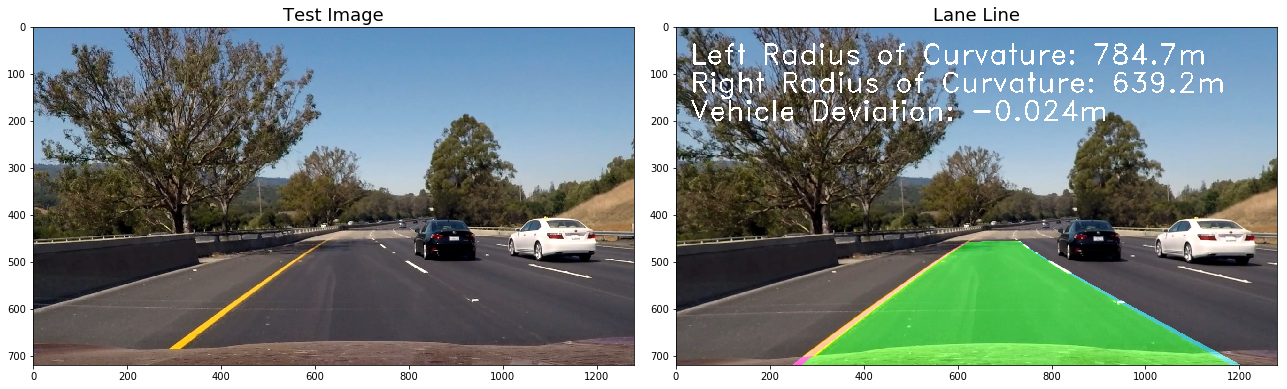

In [22]:
testPipelineImage = mpimg.imread("./test_images/test6.jpg")
laneline = pipeline(testPipelineImage)
plotImages(testPipelineImage, "Test Image", laneline, "Lane Line")
mpimg.imsave("./output_images/test6_lane_line_final.jpg", laneline)

### Project Video

In [23]:
from moviepy.editor import VideoFileClip

videoOutput = "project_video_output.mp4"
#videoInput = VideoFileClip("project_video.mp4").subclip(40,44)
videoInput = VideoFileClip("project_video.mp4")

processedVideo = videoInput.fl_image(pipeline)

%time processedVideo.write_videofile(videoOutput, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:08<00:00,  7.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 23s, sys: 11.9 s, total: 3min 35s
Wall time: 3min 9s


In [24]:
from IPython.display import HTML

HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(videoOutput))